# Test if skewness trend is real or nothing!

## 1. Null Test
- same model as from wavy_mach_test.ipynb, but with no underlying geometry
- completely disordered field

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, skewnorm

In [3]:
def null_random_field_test(M_A, Bz_true, g_size, plotting=False):
    """
    Null hypothesis: random POS magnetic field orientations.
    No underlying geometry.
    """

    # =========================
    # REGIME CLASSIFICATION
    # =========================
    if M_A < 0.5:
        sigma_phi = M_A
    elif M_A <= 1.0:
        sigma_phi = M_A
    else:
        sigma_phi = M_A

    I0 = 1.0
    Bx0, By0 = 1.0, 1.0
    corr_r = 0.9

    # =========================
    # GRID
    # =========================
    x = np.linspace(-np.pi, np.pi, g_size)
    y = np.linspace(-np.pi, np.pi, g_size)
    z = np.linspace(-np.pi, np.pi, g_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing="xy")

    # =========================
    # RANDOM POS FIELD
    # =========================
    theta0 = np.random.uniform(0, np.pi, size=(g_size, g_size, g_size))

    Bx = Bx0 * np.cos(theta0)
    By = By0 * np.sin(theta0)
    Bz = np.ones_like(Bx) * Bz_true

    # =========================
    # LOS TURBULENCE (AR(1))
    # =========================
    delta_theta = np.zeros_like(Bx)

    for ix in range(g_size):
        for iy in range(g_size):
            val = np.random.normal(scale=sigma_phi)
            for iz in range(g_size):
                delta_theta[ix, iy, iz] = val
                val = corr_r * val + np.random.normal(scale=sigma_phi * np.sqrt(1 - corr_r**2))

    # rotate POS field
    Bx_r = Bx * np.cos(delta_theta) - By * np.sin(delta_theta)
    By_r = Bx * np.sin(delta_theta) + By * np.cos(delta_theta)

    Bx, By = Bx_r, By_r

    # =========================
    # STOKES
    # =========================
    Bperp2 = Bx**2 + By**2
    Btot2 = Bperp2 + Bz**2 + 1e-12

    q = (By**2 - Bx**2) / Btot2
    u = (2 * Bx * By) / Btot2

    Q = I0 * q
    U = I0 * u

    # =========================
    # LOS INTEGRATION
    # =========================
    Q_obs = Q.sum(axis=2)
    U_obs = U.sum(axis=2)
    I_obs = I0 * g_size

    P_obs = np.sqrt(Q_obs**2 + U_obs**2) / I_obs
    phi_obs = 0.5 * np.arctan2(U_obs, Q_obs)

    return P_obs, phi_obs


# 2. Hypothesis test
- using same model from wavy_mach_test.ipynb

In [4]:
def wavy_mach_test(M_A, Bz_true, amplitude_range, g_size, plotting=False):
    """
    ISM toy polarization model with LOS turbulence parameterized
    by Alfvénic Mach number M_A.
    """

    # =========================
    # REGIME CLASSIFICATION
    # =========================
    if M_A < 0.5:
        regime = "sub-Alfvénic"
        sigma_phi = M_A
    elif 0.5 <= M_A <= 1.0:
        regime = "trans-Alfvénic"
        sigma_phi = M_A
    else:
        regime = "super-Alfvénic"
        # Saturate angular dispersion (randomized field limit)
        sigma_phi = M_A
        regime = "Super-Alfvénic regime: angular dispersion saturated; DCF assumptions invalid."

    print(f"Operating regime: {regime} (M_A = {M_A:.2f})")

    # =========================
    # PARAMETERS
    # =========================
    I0 = 1.0
    frequency = 1.0
    amplitude = np.linspace(amplitude_range[0], amplitude_range[1], g_size)

    Bx0, By0 = 1.0, 1.0
    corr_r = 0.9   # LOS correlation coefficient

    # =========================
    # GRID
    # =========================
    x = np.linspace(-np.pi, np.pi, g_size)
    y = np.linspace(-np.pi, np.pi, g_size)
    z = np.linspace(-np.pi, np.pi, g_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing="xy")

    Bx = np.zeros_like(X)
    By = np.zeros_like(Y)
    Bz = np.zeros_like(Z)

    # =========================
    # LARGE-SCALE POS FIELD
    # =========================
    for iz in range(g_size):
        theta0 = amplitude[iz] * np.cos(frequency * X[:, :, iz])
        Bx[:, :, iz] = Bx0 * np.cos(theta0)
        By[:, :, iz] = By0 * np.sin(theta0)
        Bz[:, :, iz] = Bz_true

    # =========================
    # LOS TURBULENCE (AR(1))
    # =========================
    delta_theta = np.zeros((g_size, g_size, g_size))

    for ix in range(g_size):
        for iy in range(g_size):
            val = np.random.normal(scale=sigma_phi)
            for iz in range(g_size):
                delta_theta[ix, iy, iz] = val
                val = corr_r * val + np.random.normal(
                    scale=sigma_phi * np.sqrt(1 - corr_r**2)
                )

    # =========================
    # APPLY TURBULENT ROTATION
    # =========================
    Bx_rot = Bx * np.cos(delta_theta) - By * np.sin(delta_theta)
    By_rot = Bx * np.sin(delta_theta) + By * np.cos(delta_theta)

    Bx, By = Bx_rot, By_rot

    # =========================
    # OPTIONAL FIELD PLOTTING
    # =========================
    if plotting:
        fig, ax = plt.subplots(1, g_size, figsize=(18, 2))
        for iz in range(g_size):
            ax[iz].quiver(
                X[:, :, iz], Y[:, :, iz],
                Bx[:, :, iz], By[:, :, iz],
                pivot="middle",
                scale=2,
                scale_units="xy",
                headlength=0,
                headaxislength=0
            )
            ax[iz].set_title(f"z={iz}")
        plt.tight_layout()
        plt.show()

    # =========================
    # STOKES FROM FIELD
    # =========================
    Bperp2 = Bx**2 + By**2
    Btot2 = Bperp2 + Bz**2 + 1e-12

    cos2g = Bperp2 / Btot2
    q = (By**2 - Bx**2) / Btot2
    u = (2 * Bx * By) / Btot2

    Q3 = I0 * q
    U3 = I0 * u

    # =========================
    # LOS INTEGRATION
    # =========================
    Q_obs = Q3.sum(axis=2)
    U_obs = U3.sum(axis=2)
    I_obs = I0 * g_size

    P_obs = np.sqrt(Q_obs**2 + U_obs**2) / I_obs
    phi_obs = 0.5 * np.arctan2(U_obs, Q_obs)
    cos2g_LOS = cos2g.mean(axis=2)

    return P_obs, phi_obs, cos2g_LOS


# 3. Run both tests and compare

Operating regime: sub-Alfvénic (M_A = 0.25)
Operating regime: trans-Alfvénic (M_A = 0.50)
Operating regime: trans-Alfvénic (M_A = 1.00)
Operating regime: Super-Alfvénic regime: angular dispersion saturated; DCF assumptions invalid. (M_A = 2.00)


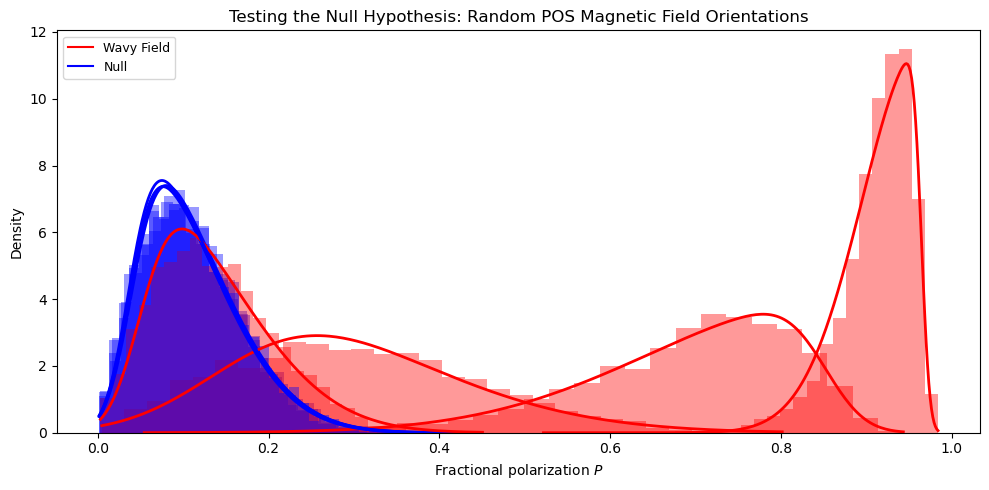

In [5]:
from scipy.stats import skew, skewnorm

plt.figure(figsize=(10, 5))
# mach_vals = [0.2,0.3, 0.4, 0.5,0.75,1,1.5,2,3]
mach_vals = [0.25,0.5,1,2]
color = plt.cm.rainbow(np.linspace(0,1,len(mach_vals)+1))
color_null = plt.cm.viridis(np.linspace(0,1,len(mach_vals)+1))

skew_geom = []
skew_null = []

for imach in mach_vals:

    # simulate
    P, PHI, C = wavy_mach_test(M_A=imach,Bz_true=0,amplitude_range=[1, 1],g_size=64,plotting=False)
    # Null
    Pn, _ = null_random_field_test(M_A=imach, Bz_true=0, g_size=64)

    Pflat = P.flatten()
    Pnflat = Pn.flatten()

    Pflat = Pflat[Pflat > 0]
    Pnflat = Pnflat[Pflat > 0]

    # --- compute raw skewness ---
    skew_geom.append(skew(Pflat, bias=False))
    skew_null.append(skew(Pnflat, bias=False))

    # --- fit skewnormal distribution ---
    a, loc, scale       = skewnorm.fit(Pflat)
    a_n, loc_n, scale_n = skewnorm.fit(Pnflat)

    # build PDF for plotting
    x = np.linspace(Pflat.min(), Pflat.max(), 300)
    pdf_skew = skewnorm.pdf(x, a, loc=loc, scale=scale)

    x_n = np.linspace(Pnflat.min(), Pnflat.max(), 300)
    pdf_skew_n = skewnorm.pdf(x_n, a_n, loc=loc_n, scale=scale_n)

    # --- histogram ---
    plt.hist(Pflat, bins=30, density=True, alpha=0.4, color = 'red')
    plt.hist(Pnflat, bins=30, density=True, alpha=0.4, color = 'blue')

    # --- overlay skewnormal fit ---
    plt.plot(x, pdf_skew, lw=2, color='red')
    plt.plot(x_n, pdf_skew_n, lw=2, color='blue')

plt.plot([], [], color='red', label='Wavy Field')
plt.plot([], [], color='blue', label='Null')
plt.xlabel("Fractional polarization $P$")
plt.ylabel("Density")
plt.title('Testing the Null Hypothesis: Random POS Magnetic Field Orientations')
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()


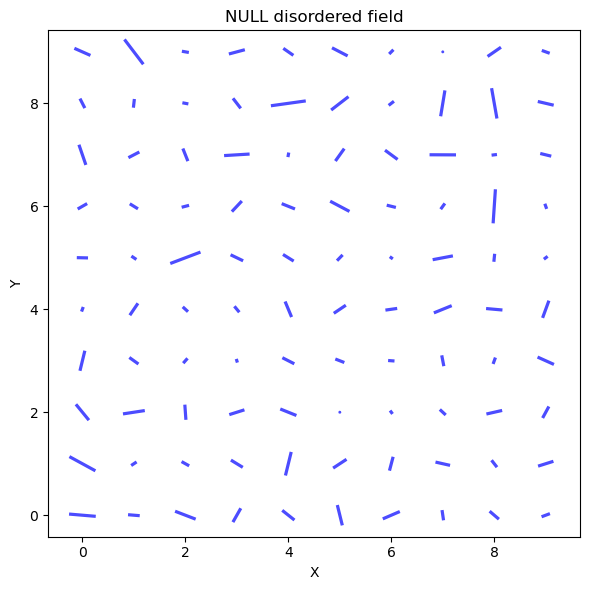

In [6]:
ngrains = 10
# P, PHI, C = wavy_field_depol_test(M_A = 1, Bz_true = 0, amplitude_range = [1,1], 
#                                       g_size = ngrains, plotting = False)

P_n, Phi_n = null_random_field_test(M_A=imach, Bz_true=0, g_size=ngrains)
# POS magnetic field components inferred from observables
Bx_obs = P_n * np.sin(Phi_n)
By_obs = P_n * np.cos(Phi_n)

ix = np.arange(ngrains)
iy = np.arange(ngrains)
XX, YY = np.meshgrid(ix, iy, indexing='xy')

plt.figure(figsize=(6, 6))

plt.quiver(XX, YY, Bx_obs, By_obs, angles='xy', scale_units='xy', scale=1, pivot='middle',
    headwidth=0, headlength=0, headaxislength=0, linewidth=1, color='blue', alpha=0.7)

plt.title("NULL disordered field")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.tight_layout()
plt.show()

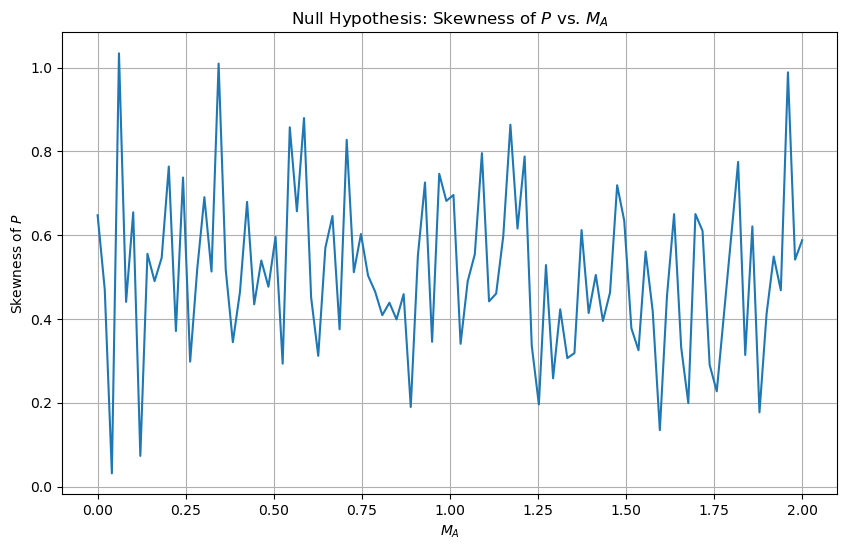

In [7]:
plt.figure(figsize=(10, 6))
n = 1
for i in range(n):
    skews = []
    # mach_vals = [0,0.25,0.5,1,2]
    mach_vals = np.linspace(0,2.0,100)
    for imach in mach_vals:
        P_n, Phi_n = null_random_field_test(M_A=imach, Bz_true=0, g_size=ngrains)
        skews.append(skew(P_n.flatten(), bias=False))

    plt.plot(mach_vals, skews, linestyle='-')
    
plt.xlabel(r"$M_A$")
plt.ylabel("Skewness of $P$")
plt.title('Null Hypothesis: Skewness of $P$ vs. $M_A$')
plt.grid(True)
plt.show()

## No trend observed for Mach No. vs. Skewness of Polarization distribution.